### micrograd 简介
> A tiny Autograd engine (with a bite! :)). Implements backpropagation (reverse-mode autodiff) over a dynamically built DAG and a small neural networks library on top of it with a PyTorch-like API. Both are tiny, with about 100 and 50 lines of code respectively. The DAG only operates over scalar values, so e.g. we chop up each neuron into all of its individual tiny adds and multiplies. However, this is enough to build up entire deep neural nets doing binary classification, as the demo notebook shows. Potentially useful for educational purposes.

手动实现反向传播（只支持标量，不支持Tensor）

Example:

```python
from micrograd.engine import Value

a = Value(-4.0)                         # a、b是输入值
b = Value(2.0)

c = a + b                               # c~f是中间变量(隐藏层), g是最终输出(输出层)
d = a * b + b**3
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()             # 每个运算都可看做一个forward pass
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g += 10.0 / f
print(f'{g.data:.4f}') # prints 24.7041, the outcome of this forward pass

g.backward()                            # 反向传播, 偏导数(梯度)根据链式法则存入涉及到的所有变量(Value类型)

# 查询梯度
print(f'{a.grad:.4f}') # 输出 138.8338, 即 dg/da
print(f'{b.grad:.4f}') # 输出 645.5773, 即 dg/db
```


#### 目标：理解Pytorch autograd库原理
+ 实现自己的micrograd engine

### 例子intro

#### 一元函数

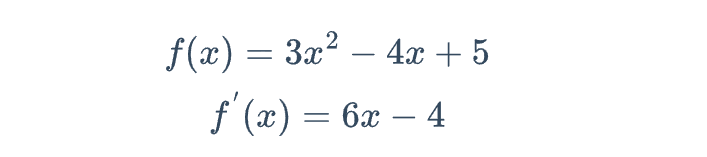

+ 神经网络中不直接进行求导，而是用反向传播

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):       # 随便写一个函数
  return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5, 5, 0.25)     # 很多个x
ys = f(xs)                      # 得到对应的y
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

##### 作图

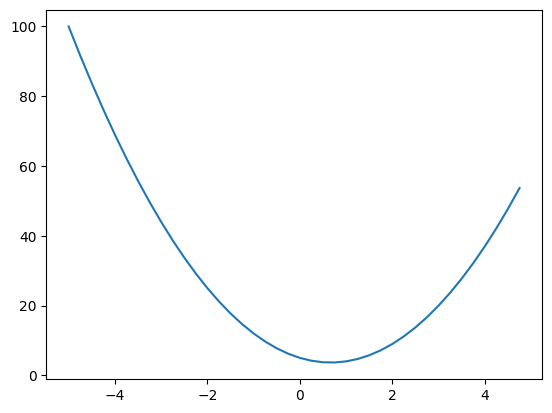

In [ ]:
plt.plot(xs, ys)

##### 求导(导数定义)

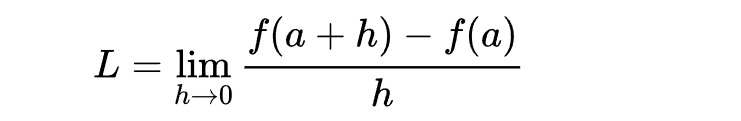

In [6]:
h = 0.0001
x = 3.0
(f(x+h) - f(x)) / h

14.000300000063248

#### 多元函数

d = a*b + c

In [ ]:
a = 2.0
b = -3.0
c = 10.0

h = 0.00001

d1 = a*b+c             # f(x)
a += h
d2 = a*b + c          # f(x+h)

print('d1', d1)
print('d2', d2)
print('斜率:', (d2-d1)/h)       # d对a的导数

d1 4.0
d2 3.9999699999999994
斜率: -3.000000000064062


### Value类
+ 模拟pytorch的Tensor类
+ 用Value类替换python的数据类型，在其中加入运算以及记录导数等功能

#### 1. 初始化+运算功能

In [12]:
class Value:
    def __init__(self, data):
        self.data = data

    def __repr__(self):             # print Value对象时会调用这个函数，类似Java的to_string()
        return f"Value(data={self.data})"
    
    # 实现几个运算功能
    def __add__(self, other):       # other也是Value对象
        out = Value(self.data + other.data)
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data)
        return out
    
    


In [24]:
a = Value(2.0)
b = Value(-3)
print(a + b)
print(a.__add__(b))
c = Value(10)
print(b+c)
print(a*b)
print(a*c)
d = a*b+c
d

Value(data=-1.0)
Value(data=-1.0)
Value(data=7)
Value(data=-6.0)
Value(data=20.0)


Value(data=4.0)

#### 2. 记录上层变量

+ 对象初始化增加_children和_op

+ 增加成员变量_prev和_op, 分别存放上层变量与运算符

+ 只有通过运算得到的变量才有children, 单独创建的变量没有, 处于最上层

In [31]:
class Value:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._prev = set(_children)     # _prev保存上一层变量
        self._op = _op                  # 保存当前对象是通过什么运算符得到的

    def __repr__(self):             # print Value对象时会调用这个函数，类似Java的to_string()
        return f"Value(data={self.data})"
    
    # 实现几个运算功能
    def __add__(self, other):       # other也是Value对象
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    

In [35]:
a = Value(-2)
b = Value(3)
c = a+b
print(c._prev)
d = c+b*a
print(d._prev)
print(d._op)

{Value(data=3), Value(data=-2)}
{Value(data=1), Value(data=-6)}
+


#### 画计算图

In [1]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


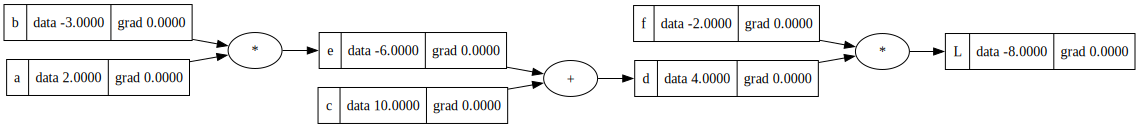

In [12]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0  # 初始化梯度为0
        self._prev = set(_children)
        self._op = _op
        self.label = label if label else str(data)  # 如果没有提供label，就用data的字符串形式

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

# 使用示例
a = Value(2, label='a')
b = Value(-3, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = c+e; d.label = 'd'
f = Value(-2.0, label='f')  
L = d * f; L.label = 'L'        # 代表 Loss function
draw_dot(L)

#### tanh (图像类似sigmoid)

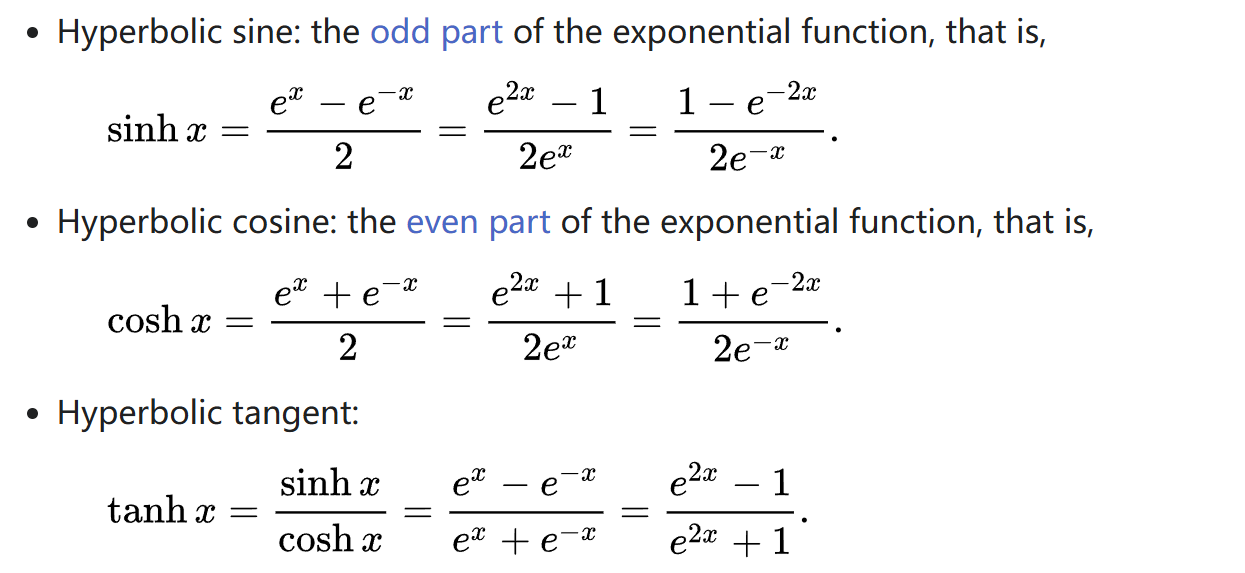

导函数：(非常容易实现)

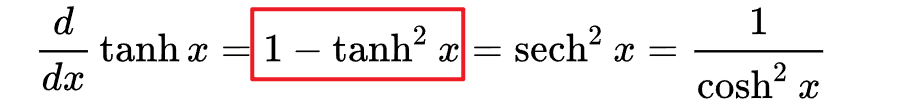

```python
def tanh(self):
    x = self.data   # 前一层
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)   # 当前层
    out = Value(t, (self, ), 'tanh')
    return out
```

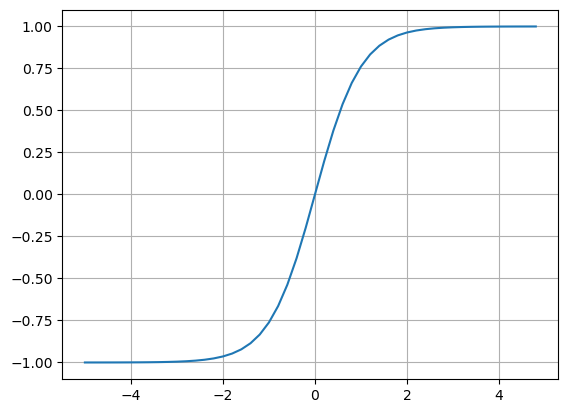

In [18]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();


In [21]:
import math
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0  # 初始化梯度为0
        self._prev = set(_children)
        self._op = _op
        self.label = label if label else str(data)  # 如果没有提供label，就用data的字符串形式

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
    def tanh(self):
        x = self.data   # 前一层
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)   # 当前层
        out = Value(t, (self, ), 'tanh')
        return out


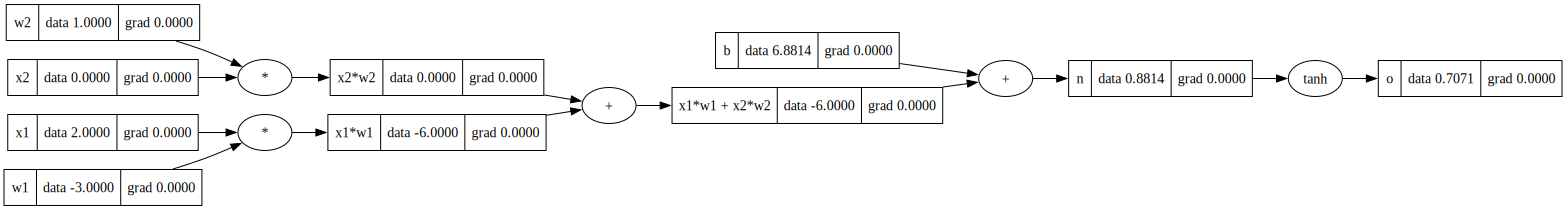

In [23]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)     # 模拟两个线性层(带bias)

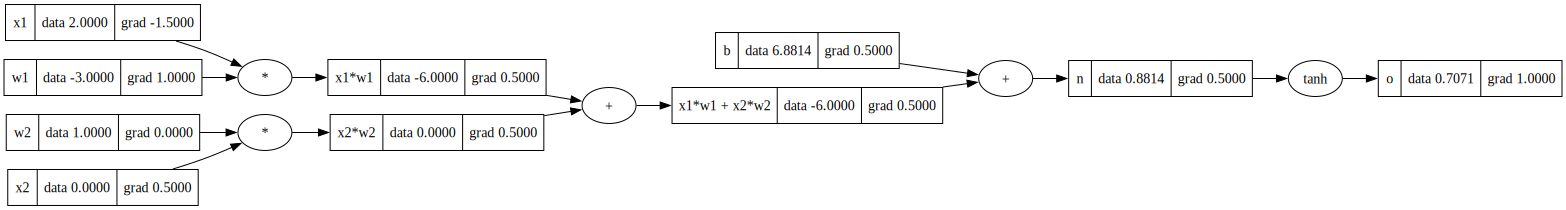

In [27]:
# 手算得：
o.grad = 1
n.grad = 0.5
b.grad = 0.5
x1w1x2w2.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x2.grad = 0.5
w2.grad = 0
x1.grad = -1.5
w1.grad = 1

draw_dot(o)

#### 3. 反向传播模块

例: \
L = d * f \
d = c + e \
e = a * b \
可得: \
L'd = f = -2, L'f = d = 4 \
L'e = L'd * d'e = -2 * 1 = -2 \
L'c = L'd * d'c = -2 * 1 = -2 \
L'a = L'e * e'a = -2 * -3 = 6 \
L'b = L'e * e'b = -2 * 2 = -4


导数定义简单实现：

In [14]:
def d():        # 导数定义求L对中间变量的导数
    
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    a.data += h
    b = Value(-3.0, label='b')
    # b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    
    # e.data += h
    # c.data += h
    d = e + c; d.label = 'd'
    # d.data += h
    f = Value(-2.0, label='f')
    # f.data += h
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)
  
d()

6.000000000000227


反向传播计算步骤：

1. 初始化L'L=1

2. 一步一步回到上一层，计算L对每一层的导数

3. 但不是用导数定义，而是根据不用的operator, 按照链式法则直接计算导数（例如'+'加法两个操作数的导数都是1）

In [28]:
import math
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0     # 存放Loss对当前变量的偏导
        self._backward = lambda: None        # 是个函数, 每个运算符都有各自的同名函数, 计算所包含的上层变量的导数

        self._prev = set(_children)
        self._op = _op
        self.label = label if label else str(data)  # 如果没有提供label，就用data的字符串形式

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():    # out对上层变量的导数都是1
            self.grad = 1.0 * out.grad      # 链式法则
            other.grad = 1.0 * out.grad
        out._backward = _backward   # 替换out的_backward成员
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward   # 替换out的_backward成员
        return out
    
    def tanh(self):
        x = self.data   # 前一层
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)   # 当前层
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = out.grad * (1.0 - t**2)      # 1 - tanh^2
        out._backward = _backward   # 替换out的_backward成员 
        return out

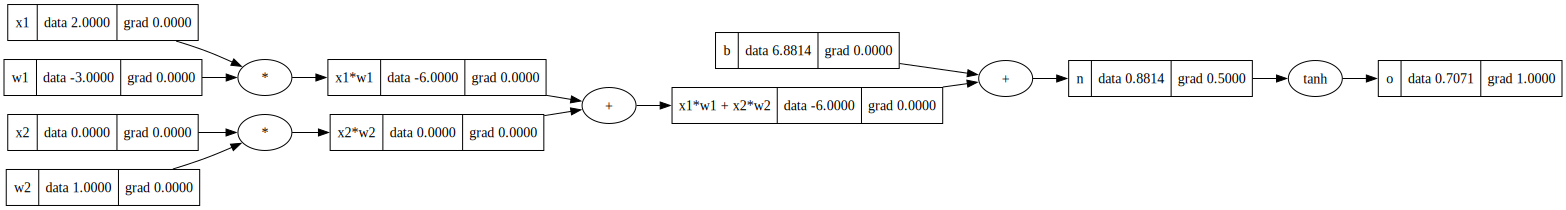

In [34]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.grad = 1.0
o._backward()
draw_dot(o)     # 模拟两个线性层(带bias)

+ backward必须严格反向按顺序调用才有效, 即`o._backward()` -> `n.backward()` -> ... \
  否则相当于什么都没干(当前的grad是0)

+ 记得要先初始化o.grad = 1.0

+ 如果x是个单独的变量(最上层), 那x.backward()就什么都没干(None)

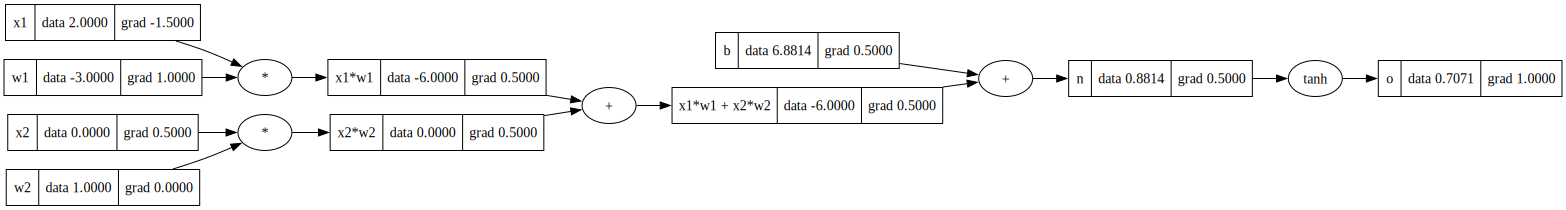

In [36]:
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
draw_dot(o)

#### 4. 逆拓扑序调用反向传播

构建逆拓扑序；

+ 递归遍历children子节点

+ 相当于树的前序遍历

In [38]:
topo = []       # 逆拓扑序
visited = set() # 已遍历过的节点集合
def build_topo(node):
    if node not in visited:
        visited.add(node)
        topo.append(node.label)
        for child in node._prev:
            build_topo(child)
    
build_topo(o)
topo

['o', 'n', 'x1*w1 + x2*w2', 'x1*w1', 'x1', 'w1', 'x2*w2', 'w2', 'x2', 'b']

+ 把上面添加节点进逆拓扑序的代码换成调用backward, 就是一次性对整个网络进行反向传播的过程

In [44]:
visited = set()
def backward(node):
    if node not in visited:
        visited.add(node)
        node._backward()
        for child in node._prev:
            backward(child)

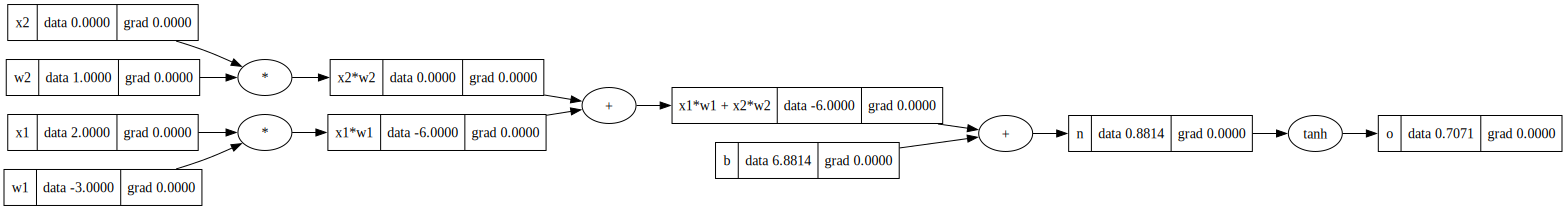

In [41]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

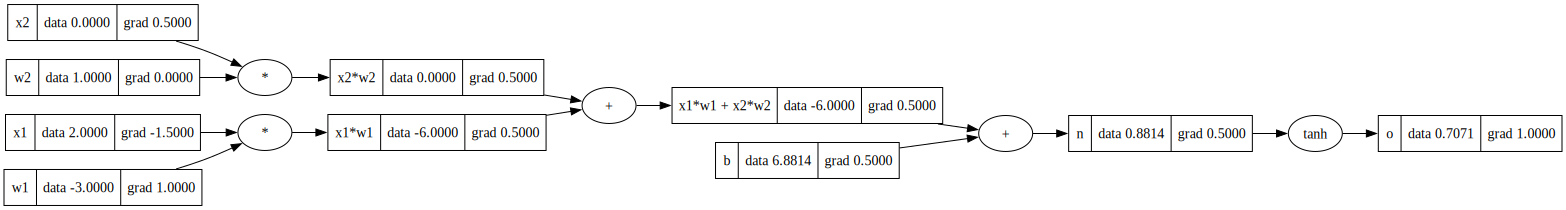

In [45]:
o.grad = 1.0
backward(o)
draw_dot(o)

添加到Value类中，作为backward函数

In [46]:
import math
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0     # 存放Loss对当前变量的偏导
        self._backward = lambda: None        # 是个函数, 每个运算符都有各自的同名函数, 计算所包含的上层变量的导数

        self._prev = set(_children)
        self._op = _op
        self.label = label if label else str(data)  # 如果没有提供label，就用data的字符串形式

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():    # out对上层变量的导数都是1
            self.grad = 1.0 * out.grad      # 链式法则
            other.grad = 1.0 * out.grad
        out._backward = _backward   # 替换out的_backward成员
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward   # 替换out的_backward成员
        return out
    
    def tanh(self):
        x = self.data   # 前一层
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)   # 当前层
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = out.grad * (1.0 - t**2)      # 1 - tanh^2
        out._backward = _backward   # 替换out的_backward成员 
        return out
    
    def backward(self):
        visited = set()
        self.grad = 1.0
        def b(node):
            if node not in visited:
                node._backward()
                visited.add(node)
                for child in node._prev:
                    b(child)
        b(self)

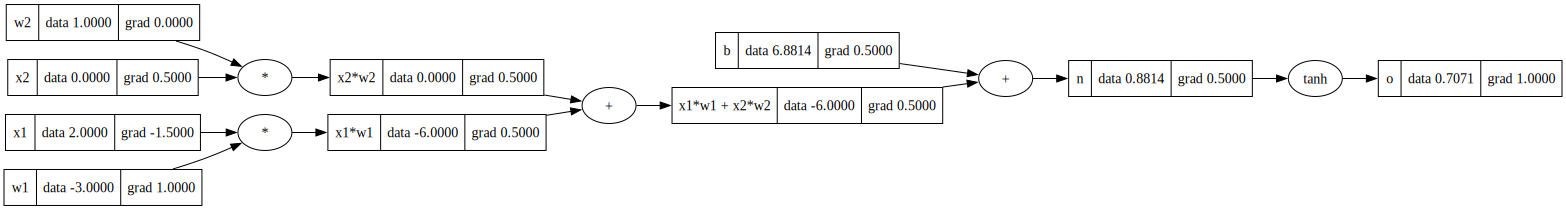

In [51]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


o.backward()
draw_dot(o)

#### bug 修复
上面的Value类有两个严重的bug：

1. 不支持重复的变量！(一个变量只能存在一次)

2. 在构造逆拓扑序时直接调用backward是错误的！ \
    例: 
```python
       a 
      / \ 
     b   c 
      \ / 
       d 
    d = b + c 
    L = d * a 

    正确backward顺序应为L->d->b/c->a
    如果在构建逆拓扑序时backward, 顺序会变成:L->c->a->b, 此时a在b之前调用backward, 造成错误，
    因为a的梯度取决于b, 而b的梯度还没有计算！


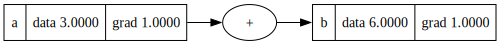

In [52]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

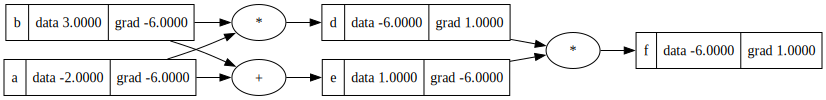

In [53]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

解决办法：重复节点的梯度需要相加（不需要新建同名节点）

+ 只需要在计算梯度时用`+=`而不是`=`

In [105]:
import math
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0     # 存放Loss对当前变量的偏导
        self._backward = lambda: None        # 是个函数, 每个运算符都有各自的同名函数, 计算所包含的上层变量的导数

        self._prev = set(_children)
        self._op = _op
        self.label = label if label else str(data)  # 如果没有提供label，就用data的字符串形式

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():    # out对上层变量的导数都是1
            self.grad += 1.0 * out.grad      # 链式法则
            other.grad += 1.0 * out.grad
        out._backward = _backward   # 替换out的_backward成员
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward   # 替换out的_backward成员
        return out
    
    def tanh(self):
        x = self.data   # 前一层
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)   # 当前层
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += out.grad * (1.0 - t**2)      # 1 - tanh^2
        out._backward = _backward   # 替换out的_backward成员 
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            print(node.label)

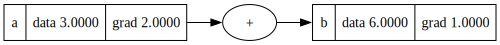

In [55]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

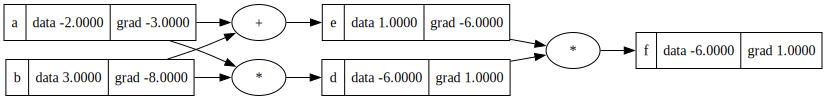

In [56]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

#### 5. 完善与拓展

+ 支持直接与python实数直接运算——> 将实数转换为Value类，新建节点
+ 交换律——> def __rmul__()
+ 减法、除法、exp、n次方

In [20]:
import math
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0     # 存放Loss对当前变量的偏导
        self._backward = lambda: None        # 是个函数, 每个运算符都有各自的同名函数, 计算所包含的上层变量的导数

        self._prev = set(_children)
        self._op = _op
        self.label = label if label else str(data)  # 如果没有提供label，就用data的字符串形式

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)     # 不是Value类就新建

        out = Value(self.data + other.data, (self, other), '+')

        def _backward():    # out对上层变量的导数都是1
            self.grad += 1.0 * out.grad      # 链式法则
            other.grad += 1.0 * out.grad
        out._backward = _backward   # 替换out的_backward成员
        return out
    
    def __radd__(self, other):      # other + self
        return self + other
    
    def __neg__(self):          # -self
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __pow__(self, other):       # n次方
        assert isinstance(other, (int, float)), '仅支持int/float类型的指数'
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):   # self / other
        return self * other ** -1
    
    def __rtruediv__(self, other): # other / self
        return other * self ** -1
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)     # 不是Value类就新建

        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward   # 替换out的_backward成员
        return out
    
    def __rmul__(self, other):      # other * self
        return self * other
    
    def tanh(self):
        x = self.data   # 前一层
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)   # 当前层
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += out.grad * (1 - t**2)      # 1 - tanh^2
        out._backward = _backward   # 替换out的_backward成员 
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

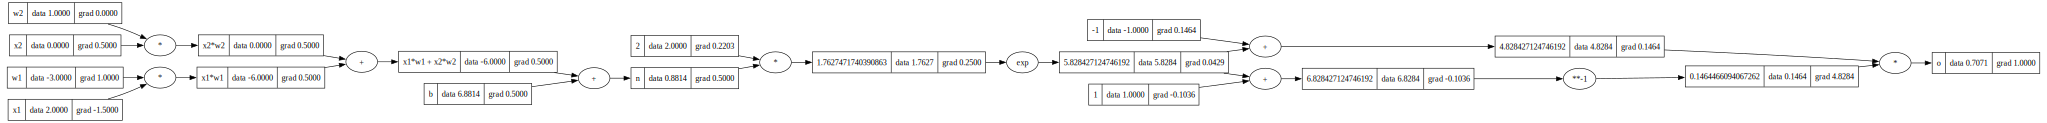

In [21]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

### 用PyTorch API实现同样操作

In [107]:
import torch
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


### Neural Net Library
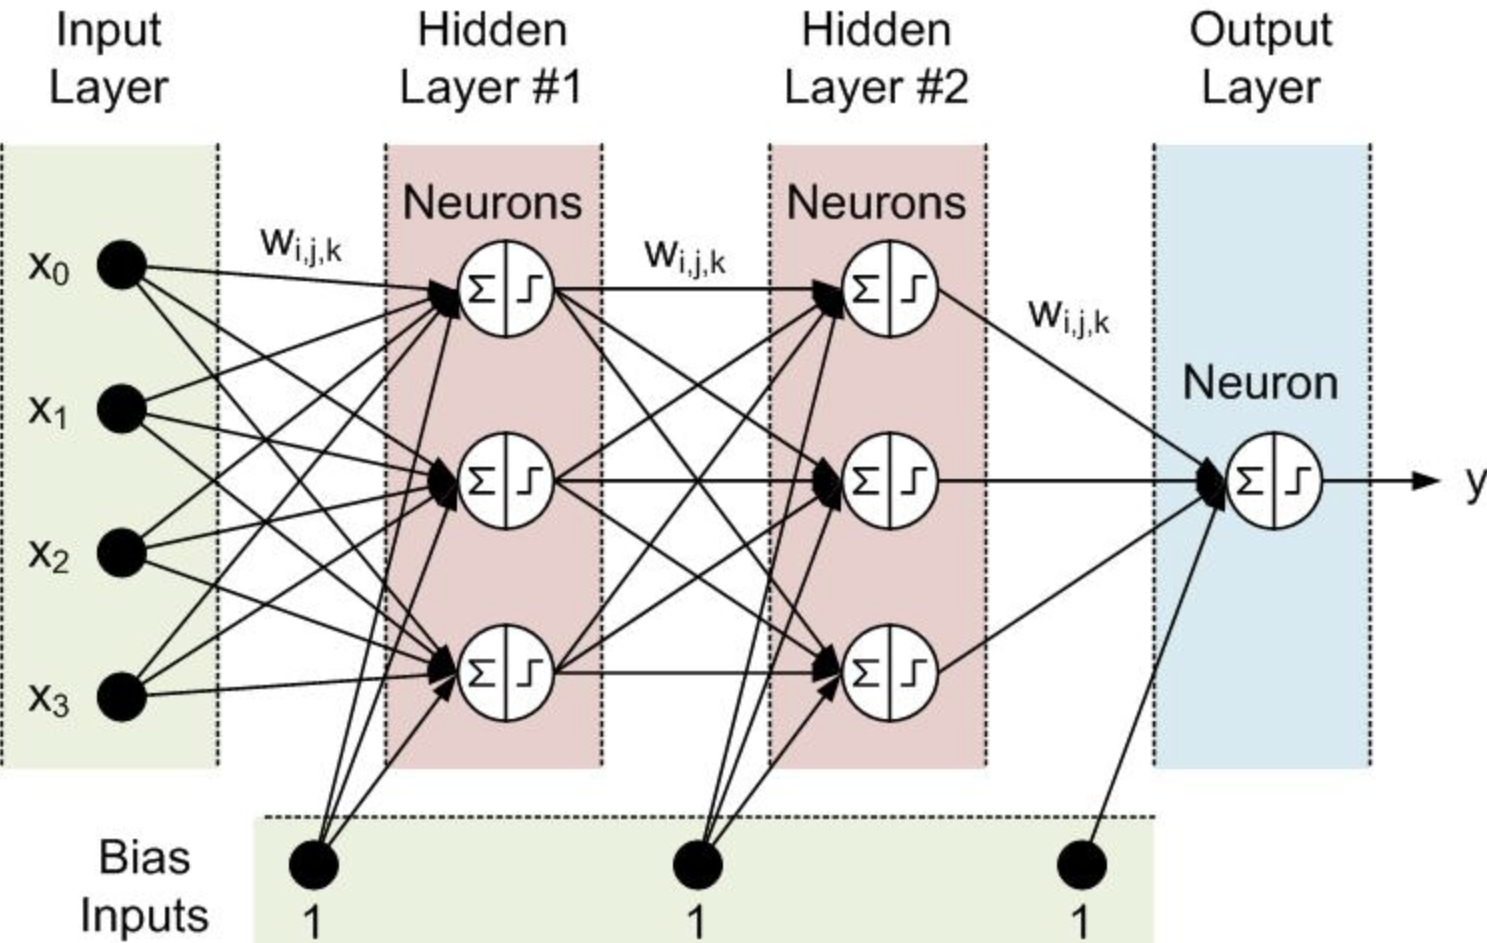
1. Neuron(单个神经元结点)

    + 数据成员：weight & bias (都是向量)

    + 功能：调用时执行w * x + b

2. Layer
   
    + 由多个neuron构成的**一个集合**


3. Model (以MLP为例)

    + 由input layer + hidden layer + output layer构成

In [ ]:
import random


class Neuron:
  
  def __init__(self, nin):    # nin代表input维度, 即前一层neuron的数量
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]  # 随机初始化(个数为前一层neuron的数量)
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):    # 调用时执行，即forward
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):     # 返回参数列表
    return self.w + [self.b]

In [4]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.9282202640075491)

In [ ]:
class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]   # nout个neuron组成的列表
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]     # 分别调用，并将输出组成列表
    return outs[0] if len(outs) == 1 else outs  # 只有一个neuron的输出层直接返回数值而不是列表
  
  def parameters(self):   # 返回每个neuron的参数组成的列表
    return [p for neuron in self.neurons for p in neuron.parameters()]

In [6]:
x = [2.0, 3.0]
n = Layer(2, 3)    # 三个neuron, 每个neuron接收两个x输入
n(x)

[Value(data=-0.9998461117768948),
 Value(data=-0.9987003457345829),
 Value(data=0.8309731850360667)]

In [ ]:
class MLP:
  
  def __init__(self, nin, nouts):   # nouts是一个列表，指定每个layer有多少个neuron
    sz = [nin] + nouts      # 合并为一个列表, sz[0] = nin, sz[1] ~ sz[n] = nouts[0] ~ nouts[n-1]
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:   # 一层一层调用
      x = layer(x)
    return x
  
  def parameters(self):       # 返回整个模型参数
  return [p for layer in self.layers for p in layer.parameters()]

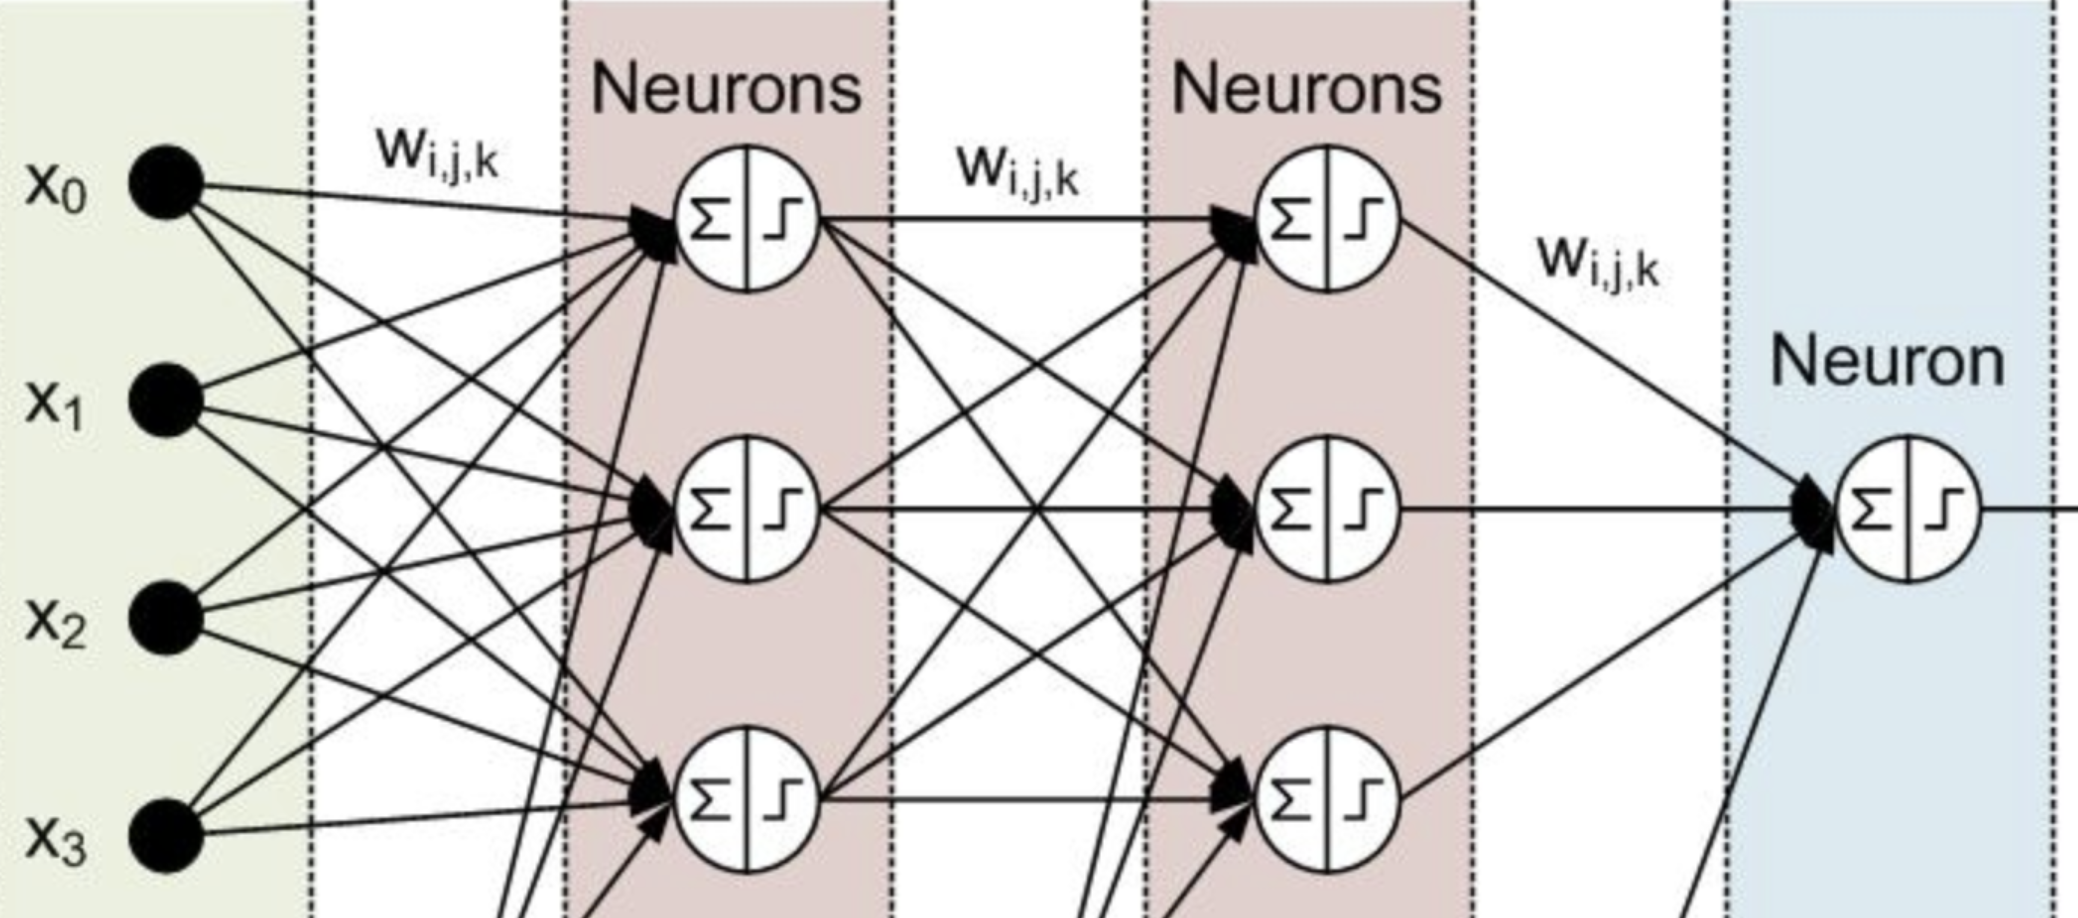

In [29]:
# 构建上图所示的MLP
x = [2.0, 3.0, -1.0, 4.0]
n = MLP(4, [3, 3, 1])    # input layer 4维, 两个hidden layer 3维, output layer 1维
y = n(x)

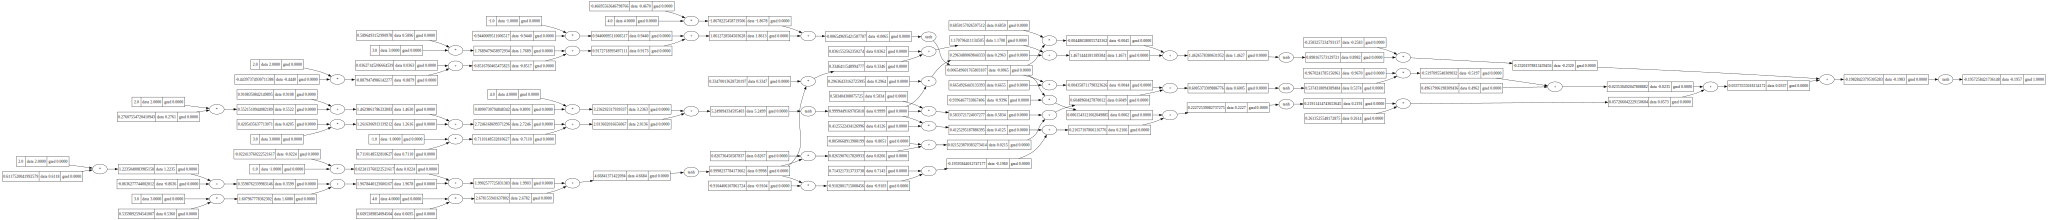

In [31]:
y.grad = 1.0
draw_dot(y)

In [32]:
y.backward()

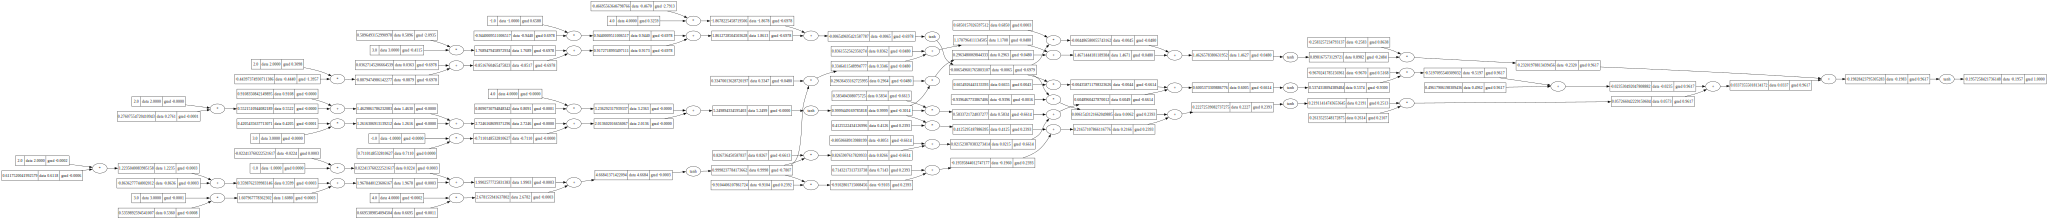

In [33]:
draw_dot(y)

### 模拟神经网络训练

In [15]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


import math
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0     # 存放Loss对当前变量的偏导
        self._backward = lambda: None        # 是个函数, 每个运算符都有各自的同名函数, 计算所包含的上层变量的导数

        self._prev = set(_children)
        self._op = _op
        self.label = label if label else str(data)  # 如果没有提供label，就用data的字符串形式

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)     # 不是Value类就新建

        out = Value(self.data + other.data, (self, other), '+')

        def _backward():    # out对上层变量的导数都是1
            self.grad += 1.0 * out.grad      # 链式法则
            other.grad += 1.0 * out.grad
        out._backward = _backward   # 替换out的_backward成员
        return out
    
    def __radd__(self, other):      # other + self
        return self + other
    
    def __neg__(self):          # -self
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __pow__(self, other):       # n次方
        assert isinstance(other, (int, float)), '仅支持int/float类型的指数'
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):   # self / other
        return self * other ** -1
    
    def __rtruediv__(self, other): # other / self
        return other * self ** -1
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)     # 不是Value类就新建

        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward   # 替换out的_backward成员
        return out
    
    def __rmul__(self, other):      # other * self
        return self * other
    
    def tanh(self):
        x = self.data   # 前一层
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)   # 当前层
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += out.grad * (1 - t**2)      # 1 - tanh^2
        out._backward = _backward   # 替换out的_backward成员 
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


#### 数据集

In [11]:
# 四个三维X, 对应四维标签y
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [51]:
# 创建模型
n = MLP(3, [3, 3, 1])
print(len(n.parameters()))
# 输入模型进行预测
ypred = [n(x) for x in xs]
ypred       # 预测值(随机预测)

28


[Value(data=0.5923408917616517),
 Value(data=0.5586775756904514),
 Value(data=0.7835345467051267),
 Value(data=0.6188399242126765)]

In [52]:
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]       # 预测值与label的差值平方作为loss

[Value(data=0.16618594852968535),
 Value(data=2.429475784960263),
 Value(data=3.1809954792906616),
 Value(data=0.14528300337419817)]

In [53]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))     # 平方误差
loss

Value(data=5.921940216154808)

#### 训练流程

In [75]:
# 创建模型
n = MLP(3, [4, 4, 1])
print(len(n.parameters()))
# 准备数据集
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

41


In [104]:
for k in range(20):     # 20个epoch
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():    # 每次更新权重需要将梯度清零，重新计算
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():    # 梯度下降
    p.data += -0.1 * p.grad    # 更新权重
  
  print(k, loss.data)
  

0 0.0016586093130480809
1 0.0016504652160216737
2 0.0016423986952295603
3 0.0016344086576068665
4 0.001626494030432216
5 0.0016186537608580387
6 0.0016108868154536783
7 0.0016031921797611047
8 0.0015955688578627434
9 0.0015880158719610105
10 0.0015805322619692767
11 0.0015731170851137066
12 0.0015657694155460098
13 0.0015584883439662624
14 0.0015512729772558802
15 0.0015441224381203236
16 0.0015370358647411673
17 0.0015300124104372368
18 0.0015230512433347535
19 0.0015161515460458313


In [ ]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9841304029439809),
 Value(data=-0.9743105063275136),
 Value(data=-0.9868882127376489),
 Value(data=0.9793699405169723)]

: 